In [49]:
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K 
from attention import AttentionLayer

In [2]:
data = pd.read_csv('Reviews.csv')

Here I'll take a sample of 10000 reviews to reduce the training time of the model

If your machine has high computational power then feel free to use the entire dataset

In [3]:
data = data.iloc[:10000]

In [4]:
data.dropna(axis = 0, inplace = True)
data.drop_duplicates(subset = ['Text'], inplace = True)

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Preprocessing

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [7]:
# data['Text'][0]
# data['Summary'][0]

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
def text_cleaner(text):
    result = text.lower()
    result = re.sub(r'\([^)]*\)','',result)
    result = re.sub('"', '', result)
    result = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in result.split(" ")])
    result = re.sub(r"'s\b'", '', result)
    result = re.sub("[^a-zA-z]", ' ', result)
    tokens = [w for w in result.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if(len(i) >= 3):
            long_words.append(i)
    result = " ".join(long_words).strip()
    return result

In [10]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [11]:
def summary_cleaner(text):
    result = text.lower()
    result = re.sub('"','', result)
    result = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in result.split(" ")])    
    result = re.sub(r"'s\b","",result)
    result = re.sub("[^a-zA-Z]", " ", result)
    tokens = result.split()
    long_words = []
    for i in tokens:
        if(len(i) >= 2):
            long_words.append(i)
    result = " ".join(long_words).strip()
    return result

In [12]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [13]:
print('Review : ', cleaned_text[0])
print('Summary :', cleaned_summary[0])

Review :  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary : good quality dog food


In [14]:
data['cleaned_summary'] = cleaned_summary
data['cleaned_text'] = cleaned_text
data['cleaned_summary'].replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

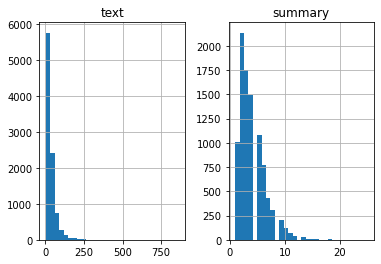

In [15]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
vis_text = pd.Series(text_word_count).value_counts()
vis_summary = pd.Series(summary_word_count).value_counts()

In [17]:
# print(vis_text[:100])
# print(vis_summary[:20])

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 10):
        cnt = cnt+1
print(cnt / len(data['cleaned_summary']))

0.9795896896370332


In [19]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 80):
        cnt = cnt+1
print(cnt / len(data['cleaned_text']))

0.9241451867438191


In [20]:
max_len_text = 80
max_len_summary = 10

In [21]:
cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_len_summary and len(cleaned_text[i].split()) <= max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
         
df = pd.DataFrame({'text':short_text,'summary':short_summary})

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok ' + x + ' eostok')

In [23]:
for i in range(2):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised eostok




In [24]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']), test_size = 0.1, random_state = 0, shuffle = True)

In [25]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [26]:
thresh = 4
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)
print("Total Coverage of rare words:",(freq / tot_freq) * 100)

% of rare words in vocabulary: 65.09420076538122
Total Coverage of rare words: 5.605145765685149


In [27]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr_seq, maxlen = max_len_text, padding = 'post')
x_val = pad_sequences(x_val_seq, maxlen = max_len_text, padding = 'post')

x_voc_size = len(x_tokenizer.word_index) + 1

In [28]:
x_voc_size

13589

In [29]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [30]:
thresh = 6
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 82.50265111346765
Total Coverage of rare words: 11.889095611925399


In [31]:
y_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

y_tr = pad_sequences(y_tr_seq, maxlen = max_len_summary, padding = 'post')
y_val = pad_sequences(y_val_seq, maxlen = max_len_summary, padding = 'post')

y_voc_size = len(y_tokenizer.word_index) + 1

In [32]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(7783, 7783)

In [33]:
ind=[]
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt+1
    if(cnt == 2):
        ind.append(i)

y_tr = np.delete(y_tr,ind, axis=0)
x_tr = np.delete(x_tr,ind, axis=0)

In [34]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if(cnt == 2):
        ind.append(i)

y_val = np.delete(y_val,ind, axis=0)
x_val = np.delete(x_val,ind, axis=0)

## Model

In [35]:
K.clear_session() 
latent_dim = 500 
embedding_dim = 100

In [51]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_dim, trainable = True)(encoder_inputs) 

#encoder LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#encoder LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences = True,return_state = True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#encoder LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state = True, return_sequences = True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape = (None,)) 
dec_emb_layer = Embedding(y_voc_size, embedding_dim, trainable = True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [52]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 80, 100)      1358900     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 80, 500), (N 1202000     embedding_8[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
_______________________________________________________________________________________

In [53]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [55]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
58/58 [==============================] - 426s 7s/step - loss: 2.7425 - val_loss: 2.1327
Epoch 2/50
58/58 [==============================] - 313s 5s/step - loss: 2.1221 - val_loss: 2.0232
Epoch 3/50
58/58 [==============================] - 649s 11s/step - loss: 2.0249 - val_loss: 1.9459
Epoch 4/50
58/58 [==============================] - 932s 16s/step - loss: 1.9711 - val_loss: 1.9069
Epoch 5/50
58/58 [==============================] - 651s 11s/step - loss: 1.9286 - val_loss: 1.8921
Epoch 6/50
58/58 [==============================] - 472s 8s/step - loss: 1.8890 - val_loss: 1.8823
Epoch 7/50
58/58 [==============================] - 785s 14s/step - loss: 1.8491 - val_loss: 1.8543
Epoch 8/50
58/58 [==============================] - 544s 9s/step - loss: 1.8011 - val_loss: 1.8284
Epoch 9/50
58/58 [==============================] - 568s 10s/step - loss: 1.7425 - val_loss: 1.7978
Epoch 10/50
58/58 [==============================] - 824s 14s/step - loss: 1.6862 - val_loss: 1.7813
Epo

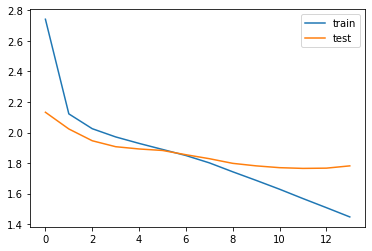

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Inference

In [59]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_hidden_state_input = Input(shape = (max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [61]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while(not stop_condition):
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
    return decoded_sentence

In [67]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
        newString = newString + reverse_target_word_index[i] + ' '
    return newString

In [68]:
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [69]:
for i in range(5):
  print("Review:", seq2text(x_val[i]))
  print("Original summary:", seq2summary(y_val[i]))
  print("Predicted summary:", decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: delicious coffee ever mess stomach amazing tastes wonderful everyone work loves 
Original summary: delicious 
Predicted summary:  great coffee


Review: never sea salt sodium free got acquired taste really like perhaps used regularly would want back perhaps salt came around world might taste different well 
Original summary: taste that needs to be 
Predicted summary:  great for pancakes


Review: like variety pack nice pick individual jars baby likes thing would suggest picky eater maybe buy one jar time test buy huge box 
Original summary: great variety 
Predicted summary:  great taste


Review: love cookies love erin result cookies make smile texture makes eyes smell reminds beautiful spring days awesome would spend erin bring fresh cookies oven enjoying together enjoying passed backyard thing kind kind much taste taste taste heaven 
Original summary: you 
Predicted summary:  cookies


Review: using protein powder month first thing noticed brand mixes better nutrition egg pro